<a href="https://colab.research.google.com/github/Polinez/ImageClassification/blob/main/Klasyfikacja_Pokemonow.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Przygotowanie bazy danych
pobieramy baze z dysku google ktora jest juz posortowana na podkatalogi

In [ ]:

#instalacja pakietu gdown
!pip install -U --no-cache-dir gdown --pre

#usuwanie i tworzenie pustego katalogu data
!rm -rf data
!rm -rf content
!rm -rf __MACOSX
!rm -rf "data 2"
!rm -rf data.zip

#pobieranie zip-a ze zdjęciami
!gdown 1ZiVjkCJ8cxXzovlyf8lByMthA1Gbhqgd -O data.zip

#rozpakowywanie pliku data.zip do katalogu data
!unzip -q data.zip

# usuwanie katalogu _MACOSX ktory nie jest nam potrzebny
!rm -rf /content/__MACOSX

Downloading...
From (original): https://drive.google.com/uc?id=1ZiVjkCJ8cxXzovlyf8lByMthA1Gbhqgd
From (redirected): https://drive.google.com/uc?id=1ZiVjkCJ8cxXzovlyf8lByMthA1Gbhqgd&confirm=t&uuid=ded79641-40b5-4595-8d00-31a3fb132d4f
To: /content/data.zip
100% 411M/411M [00:02<00:00, 150MB/s]


# Pobranie potrzebnych bibliotek oraz wizualizacja jakie dane posiadamy


## Biblioteki


In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import PIL
import tensorflow as tf
import glob
import os

from sklearn.metrics import confusion_matrix # confuxion matrix
import seaborn as sns


from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential, Model

## Ilosc zdjec

In [ ]:
image_count = len(list(glob.glob('data/**/*.png')))
print(f'{image_count} examples of pokemons')

693 examples of pokemons


## Ilosc poszczegolnej klasy

In [ ]:
folder_counts = dict()


for file_path in glob.glob('data/**/*.png', recursive=True):

    folder_name = os.path.basename(os.path.dirname(file_path))
    folder_counts[folder_name] = folder_counts.get(folder_name, 0) + 1


for folder, count in sorted(folder_counts.items()):
    print(f'{count} examples of {folder}')

63 examples of 001Bulbasaur
74 examples of 004Charmander
86 examples of 007Squirtle
64 examples of 025Pikachu
68 examples of 054Psyduck
71 examples of 068Machamp
62 examples of 130Gyarados
70 examples of 131Lapras
66 examples of 143Snorlax
69 examples of 150Mewtwo


## Wyswietlenie przykłądowego zdjecia

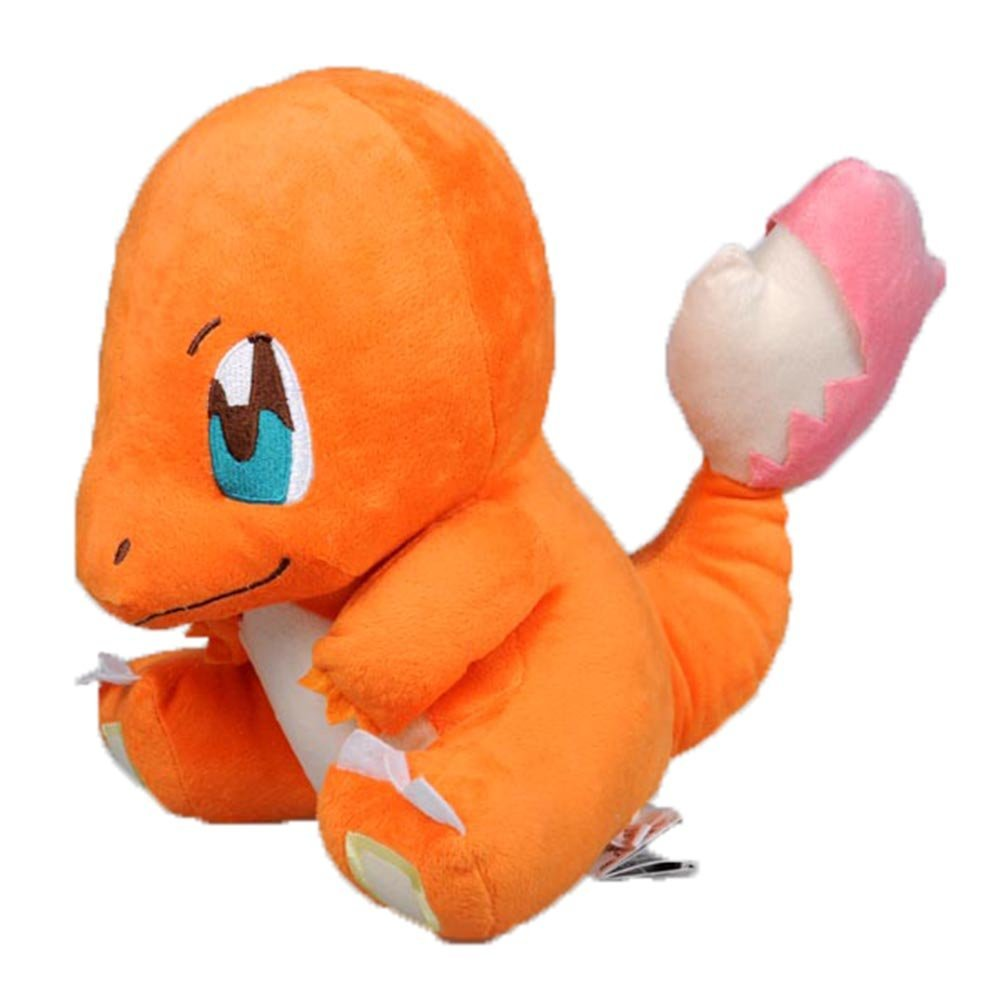

In [ ]:
pokemon = list(glob.glob('data/004*/*'))
PIL.Image.open(str(pokemon[15]))

# Uczenie modelu

In [ ]:
batch_size = 16 # liczba obrazow na raz

img_height = 128 # rozmiar obrazu po skalowaniu
img_width = 128

## Podział modelu na treninogowy i sprawdzajacy w proporccji 80 do 20

In [ ]:
train_ds = tf.keras.utils.image_dataset_from_directory(
  'data',
  validation_split=0.2,
  subset='training',
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

val_ds = tf.keras.utils.image_dataset_from_directory(
  'data',
  validation_split=0.2,
  subset='validation',
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 697 files belonging to 10 classes.
Using 558 files for training.
Found 697 files belonging to 10 classes.
Using 139 files for validation.


In [ ]:
class_names = train_ds.class_names
class_count = len(class_names)
print(f'class names: {class_names}')

class names: ['001Bulbasaur', '004Charmander', '007Squirtle', '025Pikachu', '054Psyduck', '068Machamp', '130Gyarados', '131Lapras', '143Snorlax', '150Mewtwo']


In [ ]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=tf.data.AUTOTUNE)

## Definiujemy modele

In [ ]:
def get_model(type='resnet_transfer'):
  model = None
  if type == 'resnet_transfer':
    base_model = tf.keras.applications.ResNet50(
            include_top=False,
            input_shape=(img_height, img_width, 3),
            classes=class_count,
        )
    x = layers.GlobalAveragePooling2D()(base_model.output)

    # Add a fully connected layer with a sigmoid activation for binary classification
    predictions = layers.Dense(class_count, activation='sigmoid')(x)

    # Create the final model
    model = Model(inputs=base_model.input, outputs=predictions)

  elif type == 'resnet':
    model = tf.keras.applications.ResNet50(
            weights=None,
            input_shape=(img_height, img_width, 3),
            classes=class_count,
        )

  elif type == 'custom':
    model = Sequential([
      layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
      layers.Conv2D(16, 3, padding='same', activation='relu'),
      layers.MaxPooling2D(),
      layers.Conv2D(32, 3, padding='same', activation='relu'),
      layers.MaxPooling2D(),
      layers.Conv2D(64, 3, padding='same', activation='relu'),
      layers.MaxPooling2D(),
      layers.Flatten(),
      layers.Dense(128, activation='relu'),
      layers.Dense(class_count)
    ])

  return model


## Wybor i kompilownie modelu

In [ ]:
model = get_model('resnet_transfer')
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1             │ (None, 128, 128, 3)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_pad (ZeroPadding2D) │ (None, 134, 134, 3)    │              0 │ input_layer_1[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_conv (Conv2D)       │ (None, 64, 64, 64)     │          9,472 │ conv1_pad[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_bn                  │ (None, 64, 64, 64)     │            256 │ conv1_conv[0][0]       │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_relu (Activation)   │ (None, 64, 64, 64)     │              0 │ conv1_bn[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1_pad (ZeroPadding2D) │ (None, 66, 66, 64)     │              0 │ conv1_relu[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1_pool (MaxPooling2D) │ (None, 32, 32, 64)     │              0 │ pool1_pad[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_conv       │ (None, 32, 32, 64)     │          4,160 │ pool1_pool[0][0]       │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_bn         │ (None, 32, 32, 64)     │            256 │ conv2_block1_1_conv[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_relu       │ (None, 32, 32, 64)     │              0 │ conv2_block1_1_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_conv       │ (None, 32, 32, 64)     │         36,928 │ conv2_block1_1_relu[0… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_bn         │ (None, 32, 32, 64)     │            256 │ conv2_block1_2_conv[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_relu       │ (None, 32, 32, 64)     │              0 │ conv2_block1_2_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_0_conv       │ (None, 32, 32, 256)    │         16,640 │ pool1_pool[0][0]       │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_3_conv       │ (None, 32, 32, 256)    │         16,640 │ conv2_block1_2_relu[0… │
│ (Conv2D)             

 Total params: 23,608,202 (90.06 MB)

 Trainable params: 23,555,082 (89.86 MB)

 Non-trainable params: 53,120 (207.50 KB)

## Trenowanie

In [ ]:
epochs=20
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20


/usr/local/lib/python3.11/dist-packages/keras/src/backend/tensorflow/nn.py:635: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


35/35 ━━━━━━━━━━━━━━━━━━━━ 106s 849ms/step - accuracy: 0.4663 - loss: 2.2500 - val_accuracy: 0.0935 - val_loss: 14697.4639
Epoch 2/20
35/35 ━━━━━━━━━━━━━━━━━━━━ 26s 75ms/step - accuracy: 0.6249 - loss: 1.9102 - val_accuracy: 0.0935 - val_loss: 33750.2188
Epoch 3/20
35/35 ━━━━━━━━━━━━━━━━━━━━ 3s 74ms/step - accuracy: 0.7529 - loss: 0.8618 - val_accuracy: 0.1151 - val_loss: 1174.3213
Epoch 4/20
35/35 ━━━━━━━━━━━━━━━━━━━━ 3s 75ms/step - accuracy: 0.8805 - loss: 0.4260 - val_accuracy: 0.3022 - val_loss: 13.3678
Epoch 5/20
35/35 ━━━━━━━━━━━━━━━━━━━━ 3s 83ms/step - accuracy: 0.9642 - loss: 0.1461 - val_accuracy: 0.4748 - val_loss: 3.0345
Epoch 6/20
35/35 ━━━━━━━━━━━━━━━━━━━━ 5s 80ms/step - accuracy: 0.9990 - loss: 0.0529 - val_accuracy: 0.6906 - val_loss: 1.1497
Epoch 7/20
35/35 ━━━━━━━━━━━━━━━━━━━━ 3s 75ms/step - accuracy: 0.9960 - loss: 0.0130 - val_accuracy: 0.7266 - val_loss: 1.0521
Epoch 8/20
35/35 ━━━━━━━━━━━━━━━━━━━━ 5s 84ms/step - accuracy: 1.0000 - loss: 0.0032 - val_accuracy: 0.798

# Wyswietlanie wynikow

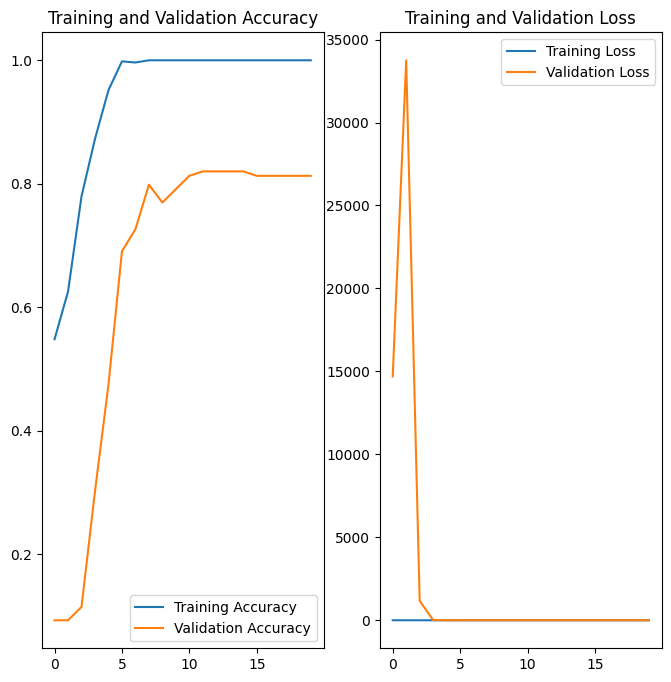

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [ ]:
# Funkcja do rysowania macierzy pomyłek
def plot_confusion_matrix(y_true, y_pred, class_names):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(10, 7))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.title('Confusion Matrix')
    plt.show()

## confusion matrix

              precision    recall  f1-score   support

           0       0.91      0.77      0.83        13
           1       0.94      0.79      0.86        19
           2       0.94      1.00      0.97        16
           3       0.62      1.00      0.76         8
           4       0.80      0.80      0.80        15
           5       0.74      0.70      0.72        20
           6       0.75      0.75      0.75        12
           7       0.75      0.69      0.72        13
           8       1.00      0.73      0.84        11
           9       0.75      1.00      0.86        12

    accuracy                           0.81       139
   macro avg       0.82      0.82      0.81       139
weighted avg       0.83      0.81      0.81       139



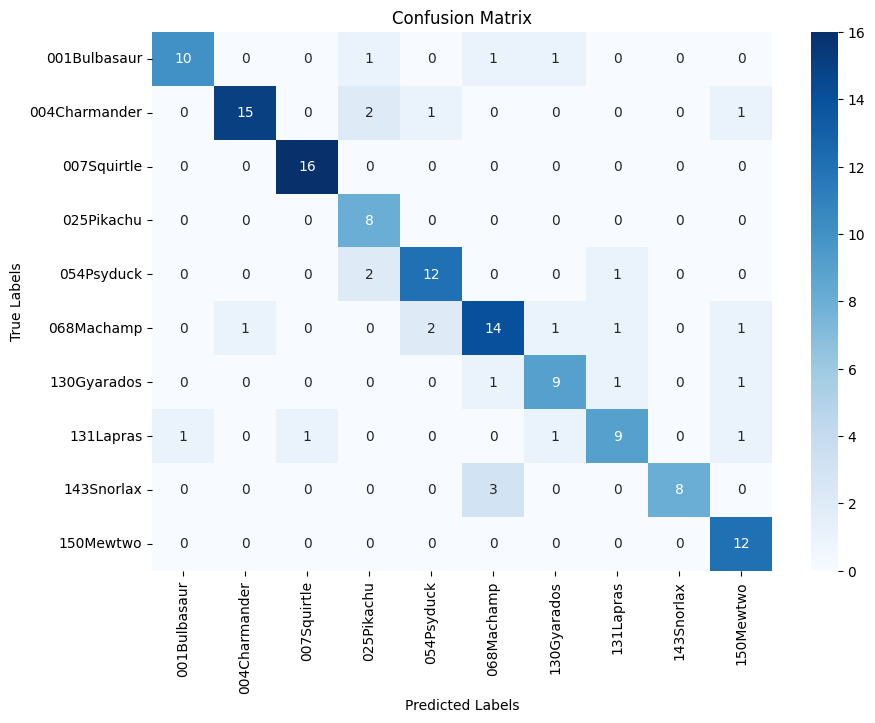

In [ ]:
from sklearn.metrics import classification_report
def evaluate_model(val_ds, model):
    y_pred = []
    y_true = []

    for batch_images, batch_labels in val_ds:
        predictions = model.predict(batch_images, verbose=0)
        y_pred = y_pred + np.argmax(tf.nn.softmax(predictions), axis=1).tolist()
        y_true = y_true + batch_labels.numpy().tolist()
    print(classification_report(y_true, y_pred))

    # Wyświetlanie macierzy pomyłek
    plot_confusion_matrix(y_true, y_pred, class_names)

evaluate_model(val_ds, model)

## jakie zdjecia zostaly zle wykrte

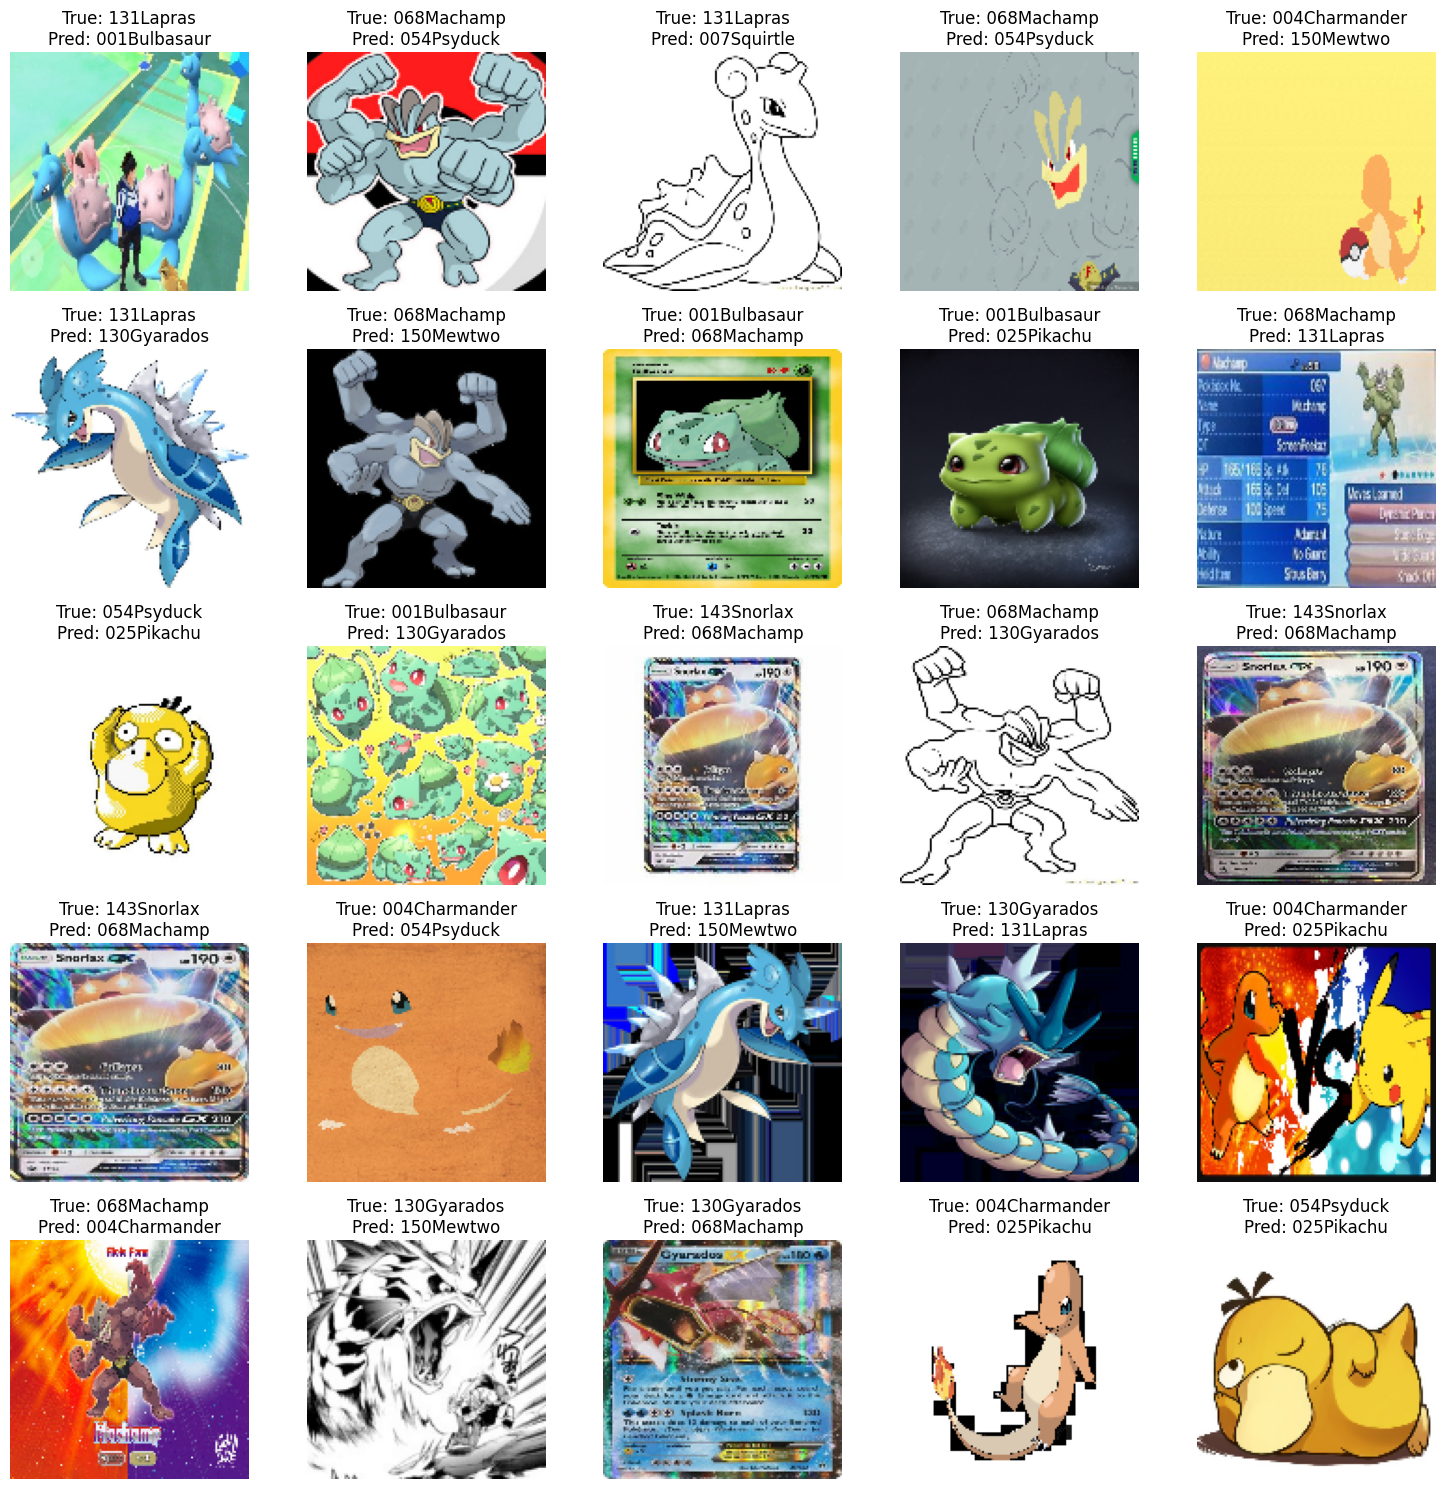

In [ ]:
def show_misclassified_images(val_ds, model, class_names):
    y_pred = []
    y_true = []
    images = []

    # Przetwarzanie walidacyjnego zbioru danych
    for batch_images, batch_labels in val_ds:
        predictions = model.predict(batch_images, verbose=0)
        y_pred.extend(np.argmax(predictions, axis=1).tolist())
        y_true.extend(batch_labels.numpy().tolist())
        images.extend(batch_images.numpy())

    # Znajdowanie błędnie zaklasyfikowanych przykładów
    misclassified_indices = [i for i in range(len(y_true)) if y_true[i] != y_pred[i]]

    # Wyświetlanie błędnie zaklasyfikowanych zdjęć
    plt.figure(figsize=(15, 15))
    for i, index in enumerate(misclassified_indices[:25]):  # Maksymalnie 25 błędów na raz
        plt.subplot(5, 5, i + 1)
        plt.imshow(images[index].astype("uint8"))
        plt.title(f"True: {class_names[y_true[index]]}\nPred: {class_names[y_pred[index]]}")
        plt.axis("off")
    plt.tight_layout()
    plt.show()

show_misclassified_images(val_ds, model, class_names)


## notatka

Accuracy to jest dobra miara jesli mamy tyle samo elementow z kazdej klasy, lecz jesli mamy rozne ilosci w kazdej klasie ta wartosc juz jest błędna.

---

Używamy wtedy:

---

Precision- ile bylo bulbazaurem sporod tych ktore zostaly sklasyfikowane jako bulbosaur

Recal- ile bylo blbazaurow sklasyfikowanych jako bulbazaur sposrod wszystkich bulbazaurow

---

Precision-  Ile z przewidzianych jako daną klasę faktycznie należało do tej klasy.

Recall- Ile z przykładów danej klasy zostało poprawnie przewidzianych z posrod wszystkich danych tej klasy

---

F1-score: Harmoniczna średnia precision i recall.

Support: Liczba próbek dla każdej klasy.

macro avg: wartosc usrendniona nie patrzac na ilosc zdj     

weighted avg: wartosc usredniona patrzec na ilosc zdjec